In [ ]:
%%bash
# Force upgrade all critical libraries to match Qwen 2.5 requirements
pip install -U -q git+https://github.com/huggingface/transformers
pip install -U -q accelerate bitsandbytes qwen-vl-utils
pip install -q pillow requests

Loading Qwen/Qwen2.5-VL-3B-Instruct in 4-bit mode...
(This configuration prevents OOM on Colab's T4 GPU)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/824 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

✅ Agent Loaded and Ready!

📷 QWEN2.5 MULTIMODAL AGENT
1. Use Demo Image (URL)
2. Upload Your Own Image
q. Quit
Select: 2


Saving Screenshot 2025-11-25 142953.png to Screenshot 2025-11-25 142953 (1).png

Input:


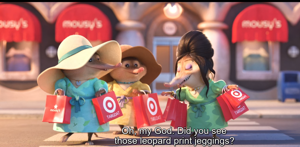


MODES:
1. Chat / Description
2. Object Detection (Grounding)
Select Mode (1 or 2): 1
Ask a question: how many rats are there in photo
⚠️ Image resized to (1024, 502) for GPU safety.
🤔 Agent is looking and thinking...

--- Agent Response ---
There are three rats in the photo.
----------------------
No bounding boxes returned. (If you wanted detection, ask: 'Detect the...')


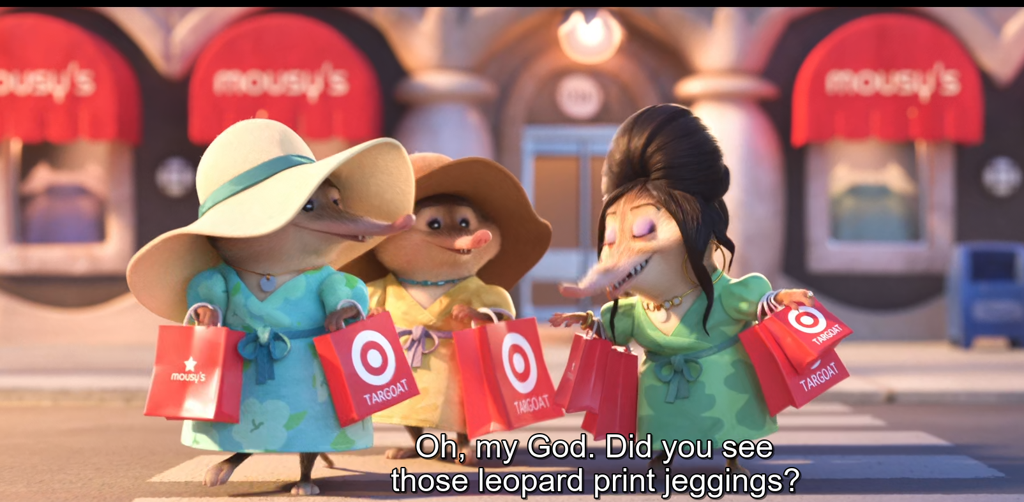


📷 QWEN2.5 MULTIMODAL AGENT
1. Use Demo Image (URL)
2. Upload Your Own Image
q. Quit
Select: 2


Saving Screenshot 2025-11-25 142953.png to Screenshot 2025-11-25 142953 (2).png

Input:


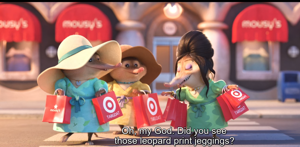


MODES:
1. Chat / Description
2. Object Detection (Grounding)
Select Mode (1 or 2): 1
Ask a question: what are the rats in photo doing
⚠️ Image resized to (1024, 502) for GPU safety.
🤔 Agent is looking and thinking...

--- Agent Response ---
The rats in the photo are shopping at Target. They are holding shopping bags with the Target logo on them, and one of them is saying, "Oh, my God. Did you see those leopard print jeggings?"
----------------------
No bounding boxes returned. (If you wanted detection, ask: 'Detect the...')


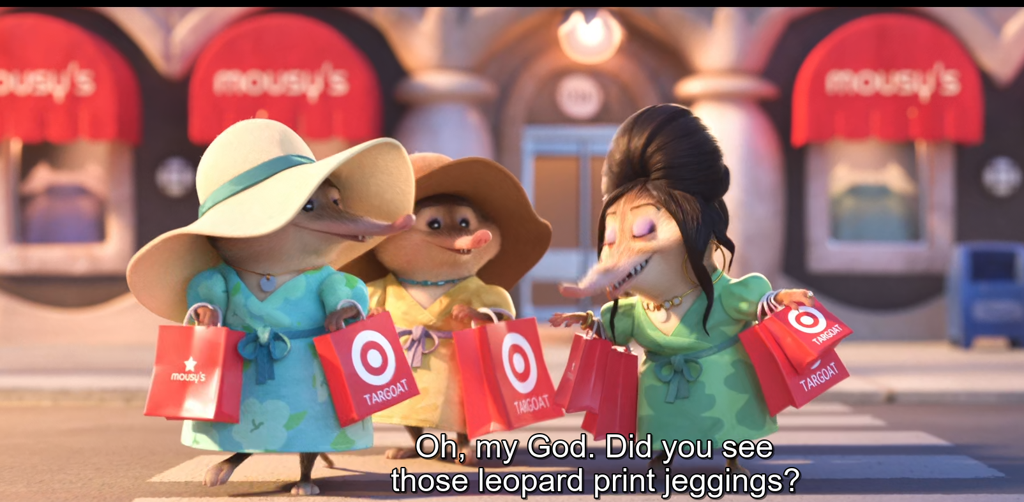


📷 QWEN2.5 MULTIMODAL AGENT
1. Use Demo Image (URL)
2. Upload Your Own Image
q. Quit
Select: q


In [ ]:
import torch
import requests
import re
import os
from PIL import Image, ImageDraw
from io import BytesIO
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
from google.colab import files


# 1. CONFIGURATION & ROBUST LOADING

MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"

def load_agent():
    print(f"Loading {MODEL_ID} in 4-bit mode...")
    print("(This configuration prevents OOM on Colab's T4 GPU)")

    # 1. Configure 4-bit Quantization (Fixes Memory Issues)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

    # 2. Load Model
    try:
        model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            MODEL_ID,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )
    except Exception as e:
        print(f"\n❌ LOAD ERROR: {e}")
        print("Did you restart the session after installing libraries?")
        raise e

    # 3. Load Processor
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    print("✅ Agent Loaded and Ready!")
    return model, processor


# 2. INFERENCE LOGIC (With Safety Resize)

def run_inference(model, processor, image, user_prompt):

    # --- SAFETY RESIZE (Fixes 'CUDA Out of Memory') ---
    # Qwen 'native resolution' explodes memory on T4 if image > 2000px.
    # We cap it at 1024px.
    max_dimension = 1024
    if max(image.size) > max_dimension:
        image.thumbnail((max_dimension, max_dimension))
        print(f"⚠️ Image resized to {image.size} for GPU safety.")

    # Create message structure
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": user_prompt},
            ],
        }
    ]

    # Process inputs
    text_prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text_prompt],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    # Generate
    print("🤔 Agent is looking and thinking...")
    generated_ids = model.generate(**inputs, max_new_tokens=512)

    # Decode result
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]

    return output_text, image


# 3. VISUALIZATION (Bounding Box Drawer)

def visualize_results(image, output_text):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    print(f"\n--- Agent Response ---\n{output_text}\n----------------------")

    # Regex to capture [x1, y1, x2, y2]
    # Qwen uses 0-1000 coordinate system
    boxes = re.findall(r'\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]', output_text)

    if boxes:
        print(f"Found {len(boxes)} object(s). Drawing boxes...")
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)

            # Convert 0-1000 scale to real pixels
            abs_x1 = (x1 / 1000) * width
            abs_y1 = (y1 / 1000) * height
            abs_x2 = (x2 / 1000) * width
            abs_y2 = (y2 / 1000) * height

            # Draw Red Box
            draw.rectangle([abs_x1, abs_y1, abs_x2, abs_y2], outline="red", width=4)

        display(image)
    else:
        print("No bounding boxes returned. (If you wanted detection, ask: 'Detect the...')")
        display(image)


# 4. MAIN INTERFACE

def main():
    # Check for T4 GPU
    if not torch.cuda.is_available():
        print("⚠️ CRITICAL WARNING: No GPU detected.")
        print("Go to Runtime > Change runtime type > Select T4 GPU.")
        return

    model, processor = load_agent()

    while True:
        print("\n" + "="*40)
        print("📷 QWEN2.5 MULTIMODAL AGENT")
        print("1. Use Demo Image (URL)")
        print("2. Upload Your Own Image")
        print("q. Quit")
        choice = input("Select: ")

        if choice.lower() == 'q':
            break

        image = None
        # Option 1: URL
        if choice == '1':
            url = input("Enter Image URL (or press Enter for default): ").strip()
            if not url:
                url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
            try:
                response = requests.get(url, stream=True)
                image = Image.open(BytesIO(response.content))
            except Exception as e:
                print(f"Error: {e}")
                continue

        # Option 2: Upload
        elif choice == '2':
            uploaded = files.upload()
            if not uploaded: continue
            filename = list(uploaded.keys())[0]
            image = Image.open(filename)

        if image:
            # Show input (resized for display)
            display_img = image.copy()
            display_img.thumbnail((300, 300))
            print("\nInput:")
            display(display_img)

            print("\nMODES:")
            print("1. Chat / Description")
            print("2. Object Detection (Grounding)")
            mode = input("Select Mode (1 or 2): ")

            if mode == '2':
                target = input("What to find? (e.g. 'the dog', 'the car'): ")
                prompt = f"Detect {target}. Return the bounding boxes."
            else:
                prompt = input("Ask a question: ")

            # Run (Pass COPY so we don't resize the original if loop continues)
            response_text, processed_img = run_inference(model, processor, image.copy(), prompt)

            # Visualize
            visualize_results(processed_img, response_text)

if __name__ == "__main__":
    main()